In [27]:
#: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [28]:
#Load and Clean Dataset
df = pd.read_csv('SN_m_tot_V2.0.csv', sep=';', header=None, comment='#',
                 names=['Year', 'Month', 'DecimalDate', 'Sunspots', 'StdDev', 'Observations', 'Definitive'])

# Replace -1 with NaN and drop missing values
df['Sunspots'] = df['Sunspots'].replace(-1, np.nan)
df.dropna(subset=['Sunspots'], inplace=True)

# Create a full datetime column
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))


In [29]:
#Preprocessing and Smoothing
# Apply 3-month rolling average to reduce sudden spikes
df['Sunspots'] = df['Sunspots'].rolling(window=3).mean()
df.dropna(inplace=True)

# Reshape for LSTM model
sunspots = df['Sunspots'].values.reshape(-1, 1)


In [30]:
# Normalize Data
scaler = MinMaxScaler()
sunspots_scaled = scaler.fit_transform(sunspots)


In [31]:
#Sequence Generation for LSTM
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

WINDOW_SIZE = 60
X, y = create_sequences(sunspots_scaled, WINDOW_SIZE)


In [32]:
# Train-Test Split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [33]:
#Build the LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')


c:\Users\PRAGATEI SHARMA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
#Train the Model
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - loss: 0.0156 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 0.0053 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0047 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - loss: 0.0048 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.0044 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - loss: 0.0037 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - loss: 0.0033 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - loss: 0.0029 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - loss: 0.0026 - val_loss: 0.0014 - learning_rate:

In [35]:
#Make Predictions and Reverse Scaling
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


In [36]:
#Evaluate Model
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

def accuracy_within_percent(y_true, y_pred, tolerance=15):
    y_true, y_pred = y_true.flatten(), y_pred.flatten()
    error = np.abs((y_true - y_pred) / y_true) * 100
    accurate_count = np.sum(error <= tolerance)
    return (accurate_count / len(y_true)) * 100

accuracy = accuracy_within_percent(y_true, y_pred, tolerance=15)

print("\n Final Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Accuracy (within ±15%): {accuracy:.2f}% ")



 Final Evaluation:
MAE: 6.62
RMSE: 8.70
R² Score: 0.9831
Accuracy (within ±15%): 69.08% 


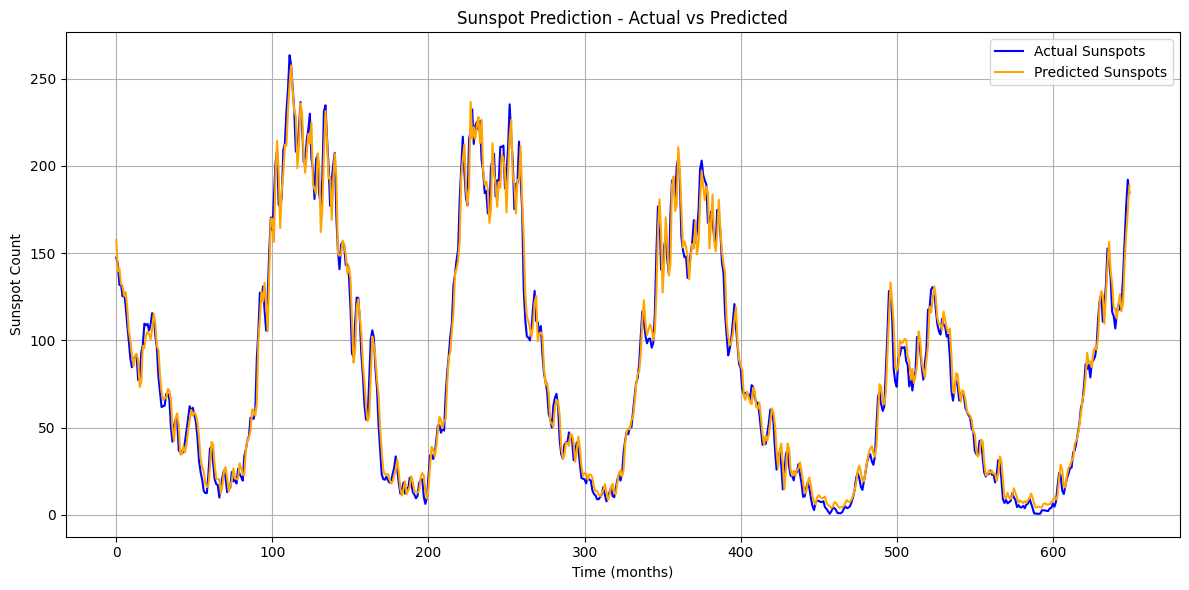

In [37]:
#Visualize Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Sunspots', color='blue')
plt.plot(y_pred, label='Predicted Sunspots', color='orange')
plt.title("Sunspot Prediction - Actual vs Predicted")
plt.xlabel("Time (months)")
plt.ylabel("Sunspot Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
#Custom Accuracy Percentage
def calculate_accuracy_percentage(y_true, y_pred, tolerance_percent=10):
    """
    Calculates how many predictions fall within a certain percentage
    of the actual values.
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # Calculate absolute percentage error
    percent_error = np.abs((y_true - y_pred) / y_true) * 100
    
    # Count how many are within tolerance
    accurate_count = np.sum(percent_error <= tolerance_percent)
    
    # Compute accuracy
    accuracy_percent = (accurate_count / len(y_true)) * 100
    return accuracy_percent


In [39]:
#accuracy = calculate_accuracy_percentage(actual_sunspots, predicted_sunspots, tolerance_percent=10)
print(f"Prediction Accuracy (within ±10% tolerance): {accuracy:.2f}%")


Prediction Accuracy (within ±10% tolerance): 69.08%


In [42]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import joblib
import numpy as np

# Assume sunspots_scaled is already created and scaled
def create_sequences(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(sunspots_scaled)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential([
    LSTM(64, input_shape=(12, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, epochs=30, batch_size=16)

# Save the model
model.save('model/lstm_model.h5')

# Save the scaler
joblib.dump(scaler, 'model/scaler.save')

# ✅ Load again (for testing or Flask)
model = load_model('model/lstm_model.h5', compile=False)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0184
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0040
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0031
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0028
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0024
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0010
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.7182e-04
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.0032e-04
Epoch 13/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.2089e-04
Epoch 14/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.6563e-04
Epoch 15/30
206/206 ━━━━━━━━━━━━━━━━━